In [221]:
import pandas as pd
import numpy as np
import scanpy as sc

In [222]:
import seaborn as sns
import matplotlib.pyplot as plt

In [223]:
from lifelines import CoxPHFitter

In [224]:
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

In [225]:
import pathlib as pl
import os

In [226]:
from typing import Dict, List

In [227]:
def pretty_ax(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)

# Define paths

In [228]:
benchmark_results_dir = pl.Path("benchmark_survival_results/")
benchmark_results_dir.mkdir(exist_ok=True)
benchmark_pred_results_dir = pl.Path("benchmark_pred_results/")
benchmark_pred_results_dir.mkdir(exist_ok=True)

In [229]:
path_tcga = pl.Path("data/raw_TCGA_data")

path_tcga_survival = pl.Path("data/Survival_SupplementalTable_S1_20171025_xena_sp")

path_tcga_phenotypes = pl.Path("data/raw_TCGA_data")

path_tcga_purity = pl.Path("data/tumor_purity.csv")
path_tcga_purity_estimate = pl.Path("data/tumor_purity_ESTIMATE.csv")

gencode_path = pl.Path("data/gencode_mapping_table.csv")

In [230]:

cancer_tcga_name = "GBM"

# Download data

In [231]:
clin_predictive = ["primary_therapy_outcome_success","pathologic_N"]

In [232]:
# gencode mapping
gencode = pd.read_csv("data/gencode_mapping_table.csv",index_col=0)

In [233]:
# FPKM UQ expression
tcga_expr = pd.read_csv(path_tcga / f"TCGA-{cancer_tcga_name}.htseq_fpkm-uq.tsv",sep="\t",index_col=0).T

tcga_expr.columns = tcga_expr.columns.str.split(".").str[0]
tcga_expr = tcga_expr.rename(columns=gencode["gene_name"])
tcga_expr = tcga_expr.loc[:,~tcga_expr.columns.str.startswith("ENSG")]
tcga_expr.index = tcga_expr.index.str[:-1]

In [234]:
# Survival and clinical info
tcga_surv = pd.read_csv(path_tcga_survival, sep="\t",index_col=0)

age = tcga_surv["age_at_initial_pathologic_diagnosis"]
age = (age - age.min())/(age.max() - age.min())
age.name = "Age"



stage_mapping = {"Stage I": 1, "Stage IB": 1, "Stage IA": 1,"I/II NOS": 1,"IS": 1,
                 "Stage II": 2, "Stage IIA": 2, "Stage IIC": 2,
                 "Stage IIB": 2, "Stage IIC": 2,  
                 "Stage III": 3, "Stage IIIA": 3, "Stage IIIB": 3, "Stage IIIC": 3,
                 "Stage IV": 4, "Stage IVA": 4, "Stage IVB": 4, "Stage IVC": 4,
                 "[Discrepancy]": np.nan, "Stage X": np.nan,"Stage 0": np.nan, "[Unknown]": np.nan}

stage = tcga_surv["ajcc_pathologic_tumor_stage"].replace(stage_mapping)
stage.name = "Stage"

surv_info = tcga_surv[["OS","OS.time"]].dropna()

In [235]:
raw_clinical = pd.read_csv(path_tcga_phenotypes / f"TCGA-{cancer_tcga_name}.GDC_phenotype.tsv",sep="\t").set_index("submitter_id.samples")

raw_clinical.index = raw_clinical.index.str[:-1]

In [236]:
mapping_clin = {"Complete Remission/Response": 0, "Progressive Disease": 1, 
                "Partial Remission/Response": 0, "Stable Disease": 0, "N0": 0, "N1": 1, 
                "N1b": 1, "NX": np.nan, "N3": 1, "N2": 1}

In [237]:
binary_pred = raw_clinical[raw_clinical.columns.intersection(clin_predictive)].replace(mapping_clin).rename(columns={"primary_therapy_outcome_success": "Therapy response", 
                            "pathologic_N": "Lymph node met."})

In [238]:
# purity info
purity = pd.read_csv(path_tcga_purity,index_col=0).set_index("Sample.ID")
purity_estimate = pd.read_csv(path_tcga_purity_estimate,index_col=0)

purity["CPE"] = purity["CPE"].str.replace(",",".").astype(float)
purity.index = purity.index.str[:-1]

if cancer_tcga_name in purity["Cancer.type"].unique():
    cancer_purity = purity[purity["Cancer.type"]==cancer_tcga_name][["CPE"]].rename(columns={"CPE": "Purity"})
else:
    cancer_purity = purity_estimate[purity_estimate["cancer_type"]==cancer_tcga_name][["TumorPurity"]].rename(columns={"TumorPurity": "Purity"})
cancer_purity = cancer_purity.loc[~cancer_purity.index.duplicated()]

In [239]:
# subset to common patients

In [240]:
common_pat = tcga_expr.index.intersection(surv_info.index)
common_pat = common_pat.intersection(cancer_purity.index)
common_pat = common_pat.intersection(binary_pred.index)
# exclude normal patients
common_pat = common_pat[~common_pat.str.endswith("10")]
common_pat = common_pat[~common_pat.str.endswith("11")]

In [241]:
tcga_expr = tcga_expr.loc[common_pat]
surv_info = surv_info.loc[common_pat]
stage = stage.loc[common_pat]
age = age.loc[common_pat]
cancer_purity = cancer_purity.loc[common_pat]
binary_pred = binary_pred.loc[common_pat]

In [242]:
std_expr = (tcga_expr - tcga_expr.mean())/tcga_expr.std()
if (stage.isna().sum()/stage.shape[0])>=0.5:
    clin = pd.concat([surv_info, age, cancer_purity],axis=1)
else:
    clin = pd.concat([surv_info, stage, age, cancer_purity],axis=1)
clin = clin.dropna()
std_expr = std_expr.loc[~std_expr.index.duplicated()]

# Score metasigs

In [243]:
# Helper functions
def get_signature_scores(std_expr: pd.DataFrame, metasigs: Dict, method: str, dataset: str, n_sigs: str):
    df = metasigs[method][dataset][n_sigs]
    score_df = []
    for sig in df.columns:
        gene_list = df[sig].ravel()
        score = std_expr.loc[:,std_expr.columns.intersection(gene_list)].mean(axis=1)
        score.name = sig
        score_df.append(score)
    score_df = pd.concat(score_df,axis=1)
    score_df = (score_df - score_df.min())/(score_df.max() - score_df.min())
    
    return score_df

def get_known_signature_scores(std_expr: pd.DataFrame, known_metasigs: Dict, cancer_name: str):
    
    score_df = []
    for sig in known_metasigs[cancer_name]:
        gene_list = known_metasigs[cancer_name][sig]
        score = std_expr.loc[:,std_expr.columns.intersection(gene_list)].mean(axis=1)
        score.name = sig
        score_df.append(score)
    score_df = pd.concat(score_df,axis=1)
    score_df = (score_df - score_df.min())/(score_df.max() - score_df.min())
    
    return score_df

def get_survival_sig(score_df: pd.DataFrame, sig: str, clinmat: pd.DataFrame, corrected: bool= False):
    
    scores = score_df[sig]
    augclin = pd.concat([clin,scores],axis=1)
    cph = CoxPHFitter()
    if corrected:
        if "Stage" in augclin.columns:
            cph.fit(augclin[["OS","OS.time",sig,"Purity","Stage",'Age']].dropna().astype(float), duration_col="OS.time", event_col="OS")
        else:
            cph.fit(augclin[["OS","OS.time",sig,"Purity",'Age']].dropna().astype(float), duration_col="OS.time", event_col="OS")
        
    else:
        cph.fit(augclin[["OS","OS.time",sig]].dropna().astype(float), duration_col="OS.time", event_col="OS")
    return cph.summary, cph

def get_full_surv_results(score_df: pd.DataFrame, clin: pd.DataFrame, corrected: bool) -> pd.DataFrame:
    res_df = []
    for s in score_df.columns:
        sig_cph, _ = get_survival_sig(score_df, s, clin, corrected=corrected)
        sig_cph = sig_cph.rename(index={"Purity": f"Purity_{s}", "Age": f"Age_{s}", "Stage": f"Stage_{s}"})
        res_df.append(sig_cph)
    res_df = pd.concat(res_df)
    
    return res_df

def get_known_sigs(path: pl.Path) -> Dict:
    known_sigs = {}
    for k in path.iterdir():
        if k.suffix==".csv":
            known_sigs[k.stem] = pd.read_csv(k).values.ravel()
    return known_sigs

In [244]:
metasigs = {}
method_path = pl.Path(f"../results/{cancer_tcga_name.lower()}/metasigs")

for f in method_path.iterdir():
    method = f.stem
    metasigs[method] = {}
    for fold in f.iterdir():

        dataset = fold.stem
        metasigs[method][dataset] = {}
        for sigdir in fold.iterdir():
            df = pd.read_csv(sigdir / "metasigs.csv")
            metasigs[method][dataset][sigdir.stem] = df
                            

In [245]:
for method in metasigs:
    for dataset in metasigs[method]:
        for n_sigs in metasigs[method][dataset]:
            savedir = benchmark_results_dir / f"{cancer_tcga_name}/{n_sigs}/{dataset}/{method}"
            os.makedirs(savedir, exist_ok=True)
            
            score_df = get_signature_scores(std_expr, metasigs, method=method, dataset=dataset, n_sigs=n_sigs)
        
            corrected_df = get_full_surv_results(score_df=score_df, clin=clin, corrected=True)
            corrected_df.to_csv(savedir / "corrected.csv")
            
            uncorrected_df = get_full_surv_results(score_df=score_df, clin=clin, corrected=False)
            uncorrected_df.to_csv(savedir / "uncorrected.csv")
            
            

# Plot results

In [246]:
method_mapping = {"bbknn": "BBKNN", "scvi": "scVI", "cca": "CCA", 
                  "unintegrated": "Unintegrated", "genenmf": "GeneNMF", 
                  "harmony": "Harmony", "scalop": "scalop", "cnmf": "GeneNMF"}

In [247]:
import yaml
def retrieve_results_pvalue_univariate(plot_res_dir: pl.Path, corrected: str, multivariate: bool):
    figure_config = yaml.safe_load(open("../figures/figures_config.yml", "r"))
    
    results = {}
    for f in plot_res_dir.iterdir():
        if f.stem==".DS_Store":
            continue
        n_sigs = f.stem
        results[n_sigs] = {}
        for dirs in f.iterdir():
            if dirs.stem==".DS_Store":
                continue
            dataset = figure_config["datasets"][dirs.stem.replace("_all_0", "")]
            results[n_sigs][dataset] = {}
            for d in dirs.iterdir():
                if d.stem!=".DS_Store":
                    method = d.stem
                    if multivariate:
                        df = pd.read_csv(d / f"multivariate_{corrected}.csv", index_col=0)
                    else:
                        df = pd.read_csv(d / f"{corrected}.csv", index_col=0)
                    df = df.loc[df.index.str.startswith("Sig.")]
                    
                    results[n_sigs][dataset][method_mapping[method]] = df

    return results

# Link with survival

In [248]:

plot_res_dir = pl.Path(f"benchmark_survival_results/{cancer_tcga_name}/")

figdir = pl.Path("benchmark_survival_results/figures")
figdir.mkdir(exist_ok=True)

In [249]:
baselines = {"LUAD": {"GEX": 0.603, "Clinical+GEX": 0.635}, 
             "GBM": {"GEX": 0.586, "Clinical+GEX": 0.583}}

palette = {"BBKNN": '#FF4433', "Harmony": '#e18632', "scVI": '#b59a32', 
  "CCA": '#39a7d6', "Unintegrated": '#8f93f4',
  "scalop": '#db70f4', "GeneNMF": '#f667c6', }

In [250]:


from typing import Tuple

from matplotlib.patches import Rectangle


def get_ds_df(results: Dict) -> Dict:

    all_dfs = []

    ds_df = {ds: [] for ds in results[list(results.keys())[0]]}

    for n_sigs in results:
        for ds in results[n_sigs]:
            sigs_df = {}
            for method in results[n_sigs][ds]:
                #maxp = results[n_sigs][ds][method]["-log2(p)"].max()
                maxp = results[n_sigs][ds][method]["p"].apply(lambda x: -np.log10(x)).max()
                sigs_df[method] = [maxp]
            sigs_df = pd.DataFrame(sigs_df).T
            sigs_df.columns = [n_sigs]
            ds_df[ds].append(sigs_df)

    for ds in ds_df:
        ds_df[ds] = pd.concat(ds_df[ds],axis=1)
    return ds_df

def get_heatmap_univariate_p(results: Dict, n_sigs: List, 
                             figsize: Tuple[float, float], 
                             width_ratios: List, vmin: float, vmax:float) -> plt.Figure:
    
    ds_df = get_ds_df(results)
    
    mean_rank = []
    for ds in ds_df:
        mean_rank.append(ds_df[ds][n_sigs].mean(axis=1).rank(ascending=False))

    mean_rank = pd.concat(mean_rank,axis=1).mean(axis=1).sort_values()
    mean_rank = mean_rank.to_frame()
    mean_rank.columns = ["Avg rank"]
    fig, ax = plt.subplots(1,len(ds_df)+1, figsize=figsize,
                           width_ratios=width_ratios)
    for i,ds in enumerate(ds_df):
        subset = ds_df[ds].loc[mean_rank.index,n_sigs]
        cbar_true = False if i<(len(ds_df)-1) else True
        sns.heatmap(data=subset, 
                cmap="vlag", annot=True, 
                    center=-np.log10(0.05), vmin=vmin, vmax=vmax,
                ax=ax[i], cbar=cbar_true)
        ax[i].set_title(ds)

        if i>0:
            ax[i].set_yticks([])
            ax[i].set_ylabel("")
        else:
            _offset = -0.95
            n_ticks = subset.shape[0]
            for j, method in enumerate(subset.index):
                rectangle = Rectangle((_offset, 1 - (j+1)/n_ticks), -_offset, 1/n_ticks, color=palette[method], transform=ax[i].transAxes, clip_on=False)
                ax[i].add_patch(rectangle)
            ax[i].yaxis.set_ticks_position('none') 

        sns.heatmap(data=mean_rank, cmap='viridis_r', annot=mean_rank, ax=ax[-1], cbar=False)
        ax[-1].set_yticks([])
        ax[-1].set_ylabel("")
        
    return fig



In [251]:

plot_res_dir = pl.Path(f"benchmark_survival_results/{cancer_tcga_name}/")

figdir = pl.Path("benchmark_survival_results/figures") 

In [252]:
results = retrieve_results_pvalue_univariate(plot_res_dir, corrected="uncorrected", multivariate=False)

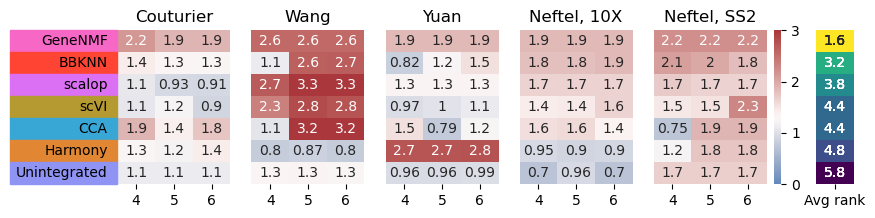

In [253]:
if cancer_tcga_name == "GBM":
    n_sigs=["4","5","6"]
    figsize=(9.5,2)
    width_ratios = [3,3,3,3,3.75,1]
    vmax=3

elif cancer_tcga_name == "LUAD":
    n_sigs=["6","7","8"]
    figsize=(6,2)
    width_ratios = [3,3,3.75,1]
    vmax = 5
else: 
    raise ValueError("Unknonw cancer type.")


fig = get_heatmap_univariate_p(results=results, 
                               n_sigs=n_sigs, 
                               figsize=figsize,
                               width_ratios = width_ratios, vmin=0, vmax=vmax)

fig.savefig(figdir / f"heatmap_univariate_p_{cancer_tcga_name}.svg", dpi=200, bbox_inches="tight")

In [254]:
list(results["6"].keys())

['Couturier', 'Wang', 'Yuan', 'Neftel, 10X', 'Neftel, SS2']

# Link with clinical features

In [255]:
method_mapping = {"bbknn": "BBKNN", "scvi": "scVI", "cca": "CCA", 
                  "unintegrated": "Unintegrated", "genenmf": "GeneNMF", 
                  "harmony": "Harmony", "scalop": "scalop", "cnmf": "GeneNMF"}

In [256]:
def get_ds_df_clinical_link(metasigs: Dict, n_sigs_list: List, std_expr: pd.DataFrame, 
                           pos_pats: np.ndarray, neg_pats: np.ndarray) -> Dict:

    ds_df = {ds: pd.DataFrame(index=list(metasigs.keys()),columns=n_sigs_list) for ds in metasigs[list(metasigs.keys())[0]]}

    for method in metasigs:
        for ds in metasigs[method]:
            for n_sigs in n_sigs_list:
                score_df = get_signature_scores(std_expr, metasigs, method=method, 
                                                dataset=ds, n_sigs=n_sigs)

                ps = []
                for sig in score_df.columns:
                    p = kruskal(score_df.loc[pos_pats,sig], score_df.loc[neg_pats,sig])[1]
                    ps.append(p)
                ds_df[ds].loc[method,n_sigs] = -np.log10(np.min(ps))

    ds_df = {ds: ds_df[ds].rename(index=method_mapping) for ds in ds_df}
    return ds_df

def get_heatmap_link_clinical(ds_df: Dict[str, pd.DataFrame], 
                              figsize: Tuple[float, float], width_ratios: List, 
                              vmin: float, vmax: float) -> plt.Figure:
    mean_rank = []
    for ds in ds_df:
        mean_rank.append(ds_df[ds].mean(axis=1).rank(ascending=False))

    mean_rank = pd.concat(mean_rank,axis=1).mean(axis=1).sort_values()
    mean_rank = mean_rank.to_frame()
    mean_rank.columns = ["Avg rank"]


    fig, ax = plt.subplots(1,len(ds_df)+1, figsize=figsize,
                           width_ratios=width_ratios)
    for i,ds in enumerate(ds_df):
        subset = ds_df[ds].loc[mean_rank.index].astype(float)
        cbar_true = False if i<(len(ds_df)-1) else True
        sns.heatmap(data=subset, 
                cmap="vlag", annot=True, 
                    vmin=vmin, vmax=vmax, center=-np.log10(0.05),
                ax=ax[i], cbar=cbar_true)
        ax[i].set_title(f"{ds}")

        if i>0:
            ax[i].set_yticks([])
            ax[i].set_ylabel("")
        else:
            _offset = -0.95
            n_ticks = subset.shape[0]
            for j, method in enumerate(subset.index):
                rectangle = Rectangle((_offset, 1 - (j+1)/n_ticks), -_offset, 1/n_ticks, color=palette[method], transform=ax[i].transAxes, clip_on=False)
                ax[i].add_patch(rectangle)
            ax[i].yaxis.set_ticks_position('none') 

        sns.heatmap(data=mean_rank, cmap='viridis_r', annot=mean_rank, ax=ax[-1], cbar=False)
        ax[-1].set_yticks([])
        ax[-1].set_ylabel("")
    return fig

Therapy response


/home/fbarkmann/miniforge3/envs/cansig-benchmark/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/fbarkmann/miniforge3/envs/cansig-benchmark/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/home/fbarkmann/miniforge3/envs/cansig-benchmark/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/fbarkmann/miniforge3/envs/cansig-benchmark/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/home/fbarkmann/miniforge3/envs/cansig-benchmark/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/fbarkmann/miniforge3/envs/cansig-benchmark/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice enco

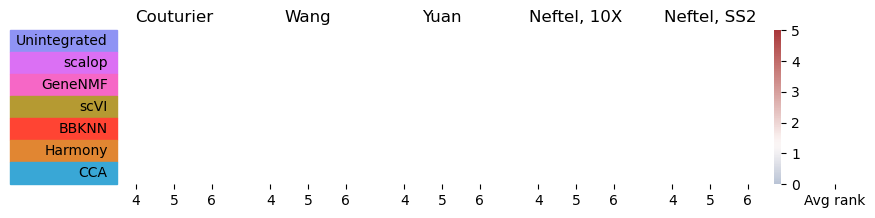

In [257]:
figure_config = yaml.safe_load(open("../figures/figures_config.yml", "r"))


if cancer_tcga_name == "GBM":
    n_sigs=["4","5","6"]
    figsize=(9.5,2)
    width_ratios = [3,3,3,3,3.75,1]
    vmax=3

elif cancer_tcga_name == "LUAD":
    n_sigs=["6","7","8"]
    figsize=(6,2)
    width_ratios = [3,3,3.75,1]
    vmax = 5
else: 
    raise ValueError("Unknonw cancer type.")

for clin_link in binary_pred.columns:
    print(clin_link)
    pos_pats = binary_pred[binary_pred[clin_link]==1].index.to_numpy()
    neg_pats = binary_pred[binary_pred[clin_link]==0].index.to_numpy()

    ds_df = get_ds_df_clinical_link(metasigs=metasigs, n_sigs_list=n_sigs, 
                                    std_expr=std_expr, 
                                   pos_pats=pos_pats, neg_pats=neg_pats)
    ds_df = {figure_config["datasets"][key.replace("_all_0", "")]: value for key, value in ds_df.items()}
    fig = get_heatmap_link_clinical(ds_df=ds_df, 
                                  figsize=figsize, width_ratios=width_ratios, 
                                  vmin=0, vmax=5)
    fig.savefig(figdir / f"clinical_heatmap_{clin_link}_{cancer_tcga_name}_log10p.svg", dpi=200, bbox_inches="tight")